# Pipeline processing using rsexecute workflows.

This notebook demonstrates the continuum imaging and ICAL pipelines. These are based on RASCIL functions wrapped
     up as SDP workflows using the rsexecute class.

In [1]:
%matplotlib inline

import sys

results_dir = '/tmp/'

from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt

from rascil.data_models.polarisation import PolarisationFrame

from rascil.processing_components import show_image, export_image_to_fits, qa_image, \
    create_low_test_image_from_gleam, create_image_from_visibility, advise_wide_field

from rascil.workflows import invert_list_rsexecute_workflow, predict_list_rsexecute_workflow, \
    simulate_list_rsexecute_workflow, continuum_imaging_list_rsexecute_workflow

from rascil.workflows.rsexecute.execution_support.rsexecute import rsexecute

import pprint

pp = pprint.PrettyPrinter()

import logging

log = logging.getLogger()
logging.info("Starting imaging-pipeline")
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))
log.addHandler(logging.StreamHandler(sys.stderr))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 


Set up rsexecute to use dask. If we are running in docker then the scheduler may be available by name.
Otherwise we just create a LocalCluster.

In [2]:
from dask.distributed import Client, LocalCluster
try:
    client = Client('scheduler:8786', timeout=10)
except OSError:
    try:
        # scheduler when run as a kubernetes cluster
        client = Client('rascil-dask-scheduler:8786', timeout=10)
    except OSError:
        client =Client(LocalCluster(processes=True, threads_per_worker=1))
print(client)

rsexecute.set_client(use_dask=True)

DEBUG:asyncio:Using selector: KqueueSelector
Using selector: KqueueSelector
DEBUG:asyncio:Using selector: KqueueSelector
Using selector: KqueueSelector
DEBUG:asyncio:Using selector: KqueueSelector
Using selector: KqueueSelector
DEBUG:asyncio:Using selector: KqueueSelector
Using selector: KqueueSelector
/Users/timcornwell/opt/anaconda3/envs/rascil37/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54746 instead
  http_address["port"], self.http_server.port
DEBUG:asyncio:Using selector: KqueueSelector
Using selector: KqueueSelector
DEBUG:asyncio:Using selector: KqueueSelector
Using selector: KqueueSelector
/Users/timcornwell/opt/anaconda3/envs/rascil37/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54815 instead
  http_address["port"], self.http_

Using selector: KqueueSelector
Using selector: KqueueSelector
Using selector: KqueueSelector
Using selector: KqueueSelector
<Client: 'tcp://127.0.0.1:54747' processes=16 threads=16, memory=68.72 GB>
Creating Dask.distributed Client
Using selector: KqueueSelector
Using selector: KqueueSelector
Diagnostic pages available on port http://127.0.0.1:54815


In [3]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)
pylab.rcParams['image.cmap'] = 'Greys'

We create a graph to make the visibility. The parameter rmax determines the distance of the furthest antenna/stations 
used. 

Finally we compute the value of the graph, a list of visibility objects. These can then be scattered to the
cluster of workers.

In [4]:
nfreqwin=7
ntimes=5
rmax=300.0
frequency=numpy.linspace(1e8,1.2e8,nfreqwin)
channel_bandwidth=numpy.array(nfreqwin*[frequency[1]-frequency[0]])
times = numpy.linspace(-numpy.pi/3.0, numpy.pi/3.0, ntimes)
phasecentre=SkyCoord(ra=+30.0 * u.deg, dec=-60.0 * u.deg, frame='icrs', equinox='J2000')

bvis_list=simulate_list_rsexecute_workflow('LOWBD2',
                                         frequency=frequency, 
                                         channel_bandwidth=channel_bandwidth,
                                         times=times,
                                         phasecentre=phasecentre,
                                         order='frequency',
                                        rmax=rmax, format='blockvis',
                                           zerow=True)

print('%d elements in vis_list' % len(bvis_list))
log.info('About to make visibility')
bvis_list = rsexecute.compute(bvis_list, sync=True)

DEBUG:rascil-logger:create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
DEBUG:rascil-logger:create_configuration_from_file: Maximum radius 300.0 m includes 94 antennas/stations
create_configuration_from_file: Maximum radius 300.0 m includes 94 antennas/stations
DEBUG:rascil-logger:simulate_list_rsexecute_workflow: Simulating distribution in frequency
simulate_list_rsexecute_workflow: Simulating distribution in frequency
INFO:root:About to make visibility
About to make visibility


create_named_configuration: LOWBD2
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: Maximum radius 300.0 m includes 94 antennas/stations
simulate_list_rsexecute_workflow: Simulating distribution in frequency
7 elements in vis_list
About to make visibility


Find the recommended values for the wide field imaging.

In [5]:
advice_low=advise_wide_field(bvis_list[0], guard_band_image=8.0, delA=0.02)
advice_high=advise_wide_field(bvis_list[-1], guard_band_image=8.0, delA=0.02)

vis_slices = advice_low['vis_slices']
npixel=advice_high['npixels2']
cellsize=min(advice_low['cellsize'], advice_high['cellsize'])

INFO:rascil-logger:advise_wide_field: (max_wavelength) Maximum wavelength 2.998 (meters)
advise_wide_field: (max_wavelength) Maximum wavelength 2.998 (meters)
INFO:rascil-logger:advise_wide_field: (min_wavelength) Minimum wavelength 2.998 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 2.998 (meters)
INFO:rascil-logger:advise_wide_field: (maximum_baseline) Maximum baseline 190.5 (wavelengths)
advise_wide_field: (maximum_baseline) Maximum baseline 190.5 (wavelengths)
INFO:rascil-logger:advise_wide_field: (maximum_w) Maximum w 0.0 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 0.0 (wavelengths)
INFO:rascil-logger:advise_wide_field: (diameter) Station/dish diameter 35.0 (meters)
advise_wide_field: (diameter) Station/dish diameter 35.0 (meters)
INFO:rascil-logger:advise_wide_field: (primary_beam_fov) Primary beam 0.0857 (rad) 4.91 (deg) 1.77e+04 (asec)
advise_wide_field: (primary_beam_fov) Primary beam 0.0857 (rad) 4.91 (deg) 1.77e+04 (asec)
INFO:rascil-logger:advis

advise_wide_field: (max_wavelength) Maximum wavelength 2.998 (meters)
advise_wide_field: (min_wavelength) Minimum wavelength 2.998 (meters)
advise_wide_field: (maximum_baseline) Maximum baseline 190.5 (wavelengths)
advise_wide_field: (maximum_w) Maximum w 0.0 (wavelengths)
advise_wide_field: (diameter) Station/dish diameter 35.0 (meters)
advise_wide_field: (primary_beam_fov) Primary beam 0.0857 (rad) 4.91 (deg) 1.77e+04 (asec)
advise_wide_field: (image_fov) Image field of view 0.685 (rad) 39.3 (deg) 1.41e+05 (asec)
advise_wide_field: (synthesized_beam) Synthesized beam 0.00525 (rad) 0.301 (deg) 1.08e+03 (asec)
advise_wide_field: (cellsize) Cellsize 0.00175 (rad) 0.1 (deg) 361 (asec)
advice_wide_field: (npixels) Npixels per side = 392
advice_wide_field: (npixels2) Npixels (power of 2) per side = 512
advice_wide_field: (npixels23) Npixels (power of 2, 3) per side = 512
advice_wide_field: (npixels_min) Npixels (power of 2, 3, 4, 5) per side = 512
advice_wide_field: (w_sampling_image) W sa

Now make a graph to fill with a model drawn from GLEAM. There will be one model image
per frequency.

In [6]:
gleam_model = [rsexecute.execute(create_low_test_image_from_gleam)(npixel=npixel,
                                                               frequency=[frequency[f]],
                                                               channel_bandwidth=[channel_bandwidth[f]],
                                                               cellsize=cellsize,
                                                               phasecentre=phasecentre,
                                                               polarisation_frame=PolarisationFrame("stokesI"),
                                                               flux_limit=1.0,
                                                               applybeam=True)
                     for f, freq in enumerate(frequency)]
log.info('About to make GLEAM model')
gleam_model = rsexecute.compute(gleam_model, sync=True)
future_gleam_model = rsexecute.scatter(gleam_model)

INFO:root:About to make GLEAM model
About to make GLEAM model


About to make GLEAM model


Now we can fill in the visibility values from the models, using a workflow.

In [7]:
log.info('About to run predict to get predicted visibility')
future_vis_graph = rsexecute.scatter(bvis_list)
predicted_vislist = predict_list_rsexecute_workflow(future_vis_graph, gleam_model, context='ng')
predicted_vislist = rsexecute.compute(predicted_vislist, sync=True)
future_predicted_vislist=rsexecute.scatter(predicted_vislist)

INFO:root:About to run predict to get predicted visibility
About to run predict to get predicted visibility


About to run predict to get predicted visibility


Get the LSM. This is blank.

In [8]:
model_list = [rsexecute.execute(create_image_from_visibility)(bvis_list[f],
                                                     npixel=npixel,
                                                     frequency=[frequency[f]],
                                                     channel_bandwidth=[channel_bandwidth[f]],
                                                     cellsize=cellsize,
                                                     phasecentre=phasecentre,
                                                     polarisation_frame=PolarisationFrame("stokesI"))
               for f, freq in enumerate(frequency)]

Make the graphs to calculate the dirty image and psf, but don't compute the values yet.

In [9]:

dirty_list = invert_list_rsexecute_workflow(future_predicted_vislist, model_list, 
                                  context='ng', dopsf=False)
psf_list = invert_list_rsexecute_workflow(future_predicted_vislist, model_list, 
                                context='ng', dopsf=True)

Compute the graphs to make the dirty image and PSF

INFO:root:About to run invert to get dirty image
About to run invert to get dirty image
INFO:root:About to run invert to get PSF
About to run invert to get PSF


About to run invert to get dirty image
About to run invert to get PSF


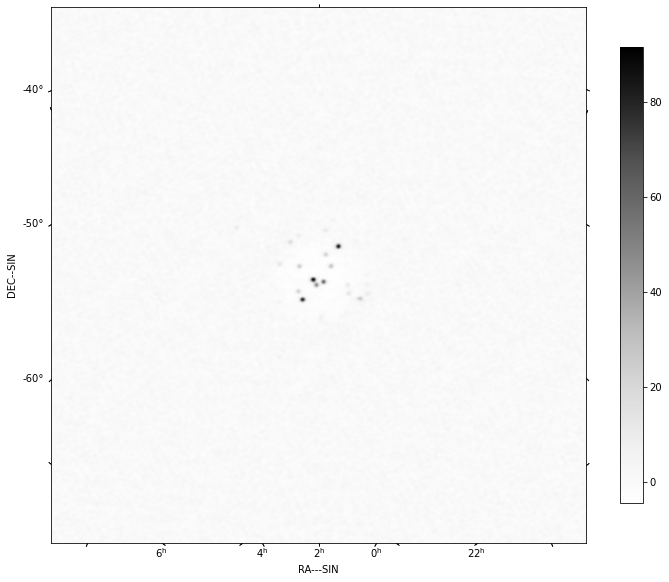

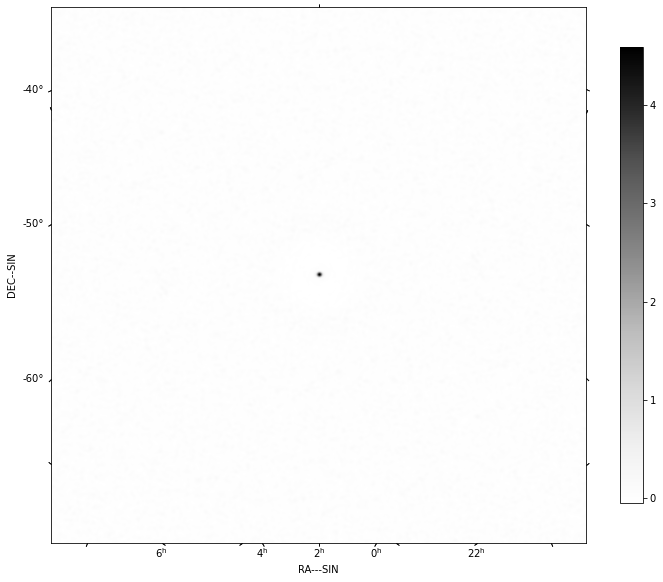

In [10]:
log.info('About to run invert to get dirty image')
dirty_list =  rsexecute.compute(dirty_list, sync=True)
dirty = dirty_list[0][0]
show_image(dirty, cm='Greys')
plt.show()

log.info('About to run invert to get PSF')
psf_list =  rsexecute.compute(psf_list, sync=True)
psf = psf_list[0][0]
show_image(psf, cm='Greys')
plt.show()

Finally we can try the continuum imaging pipeline. First construct the graph.

In [11]:
centre=nfreqwin // 2

continuum_imaging_list = continuum_imaging_list_rsexecute_workflow(future_predicted_vislist,
                                                                   model_imagelist=model_list,
                                                                   context='ng',
                                                                   algorithm='mmclean',
                                                                   scales=[0],
                                                                   niter=100, fractional_threshold=0.1,
                                                                   threshold=0.01,
                                                                   nmoment=2,
                                                                   nmajor=5, gain=0.7,
                                                                   deconvolve_facets=4, deconvolve_overlap=32,
                                                                   deconvolve_taper='tukey', psf_support=64,
                                                                   restore_facets=4, psfwidth=3.0,
                                                                  do_wstacking=False)


Now execute the graph

INFO:root:About to run continuum imaging
About to run continuum imaging


About to run continuum imaging
Quality assessment:
	Origin: qa_image
	Context: Clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '18.74560012645538'
		min: '-0.0463248586003415'
		maxabs: '18.74560012645538'
		rms: '0.06796283653466638'
		sum: '131.88081243359784'
		medianabs: '0.0'
		medianabsdevmedian: '0.0'
		median: '0.0'

Quality assessment:
	Origin: qa_image
	Context: Restored clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '19.06788276179084'
		min: '-0.21372540272871435'
		maxabs: '19.06788276179084'
		rms: '0.18692416783907767'
		sum: '2000.7360175368824'
		medianabs: '0.012645567867415271'
		medianabsdevmedian: '0.012639002331234217'
		median: '-0.00019211091517072794'

Quality assessment:
	Origin: qa_image
	Context: Residual clean image - no selfcal
	Data:
		shape: '(1, 1, 512, 512)'
		max: '1.3520394679233663'
		min: '-1.3233817877689509'
		maxabs: '1.3520394679233663'
		rms: '0.02623053936986933'
		sum: '-4.309054858546636'
		medianabs: 

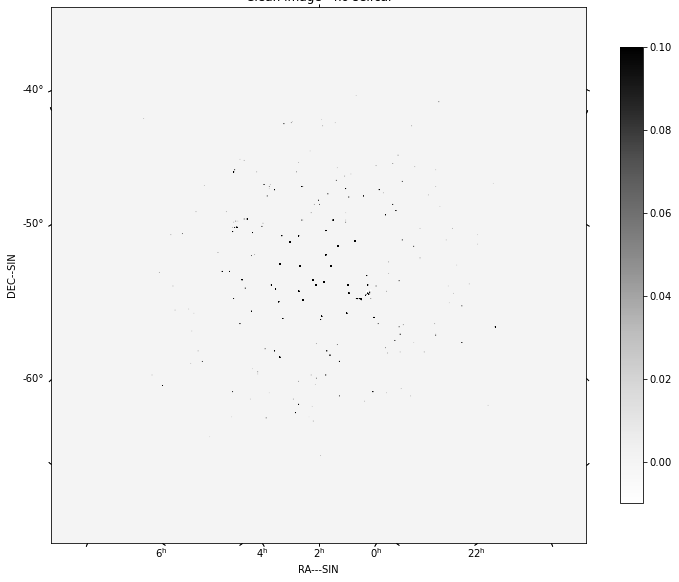

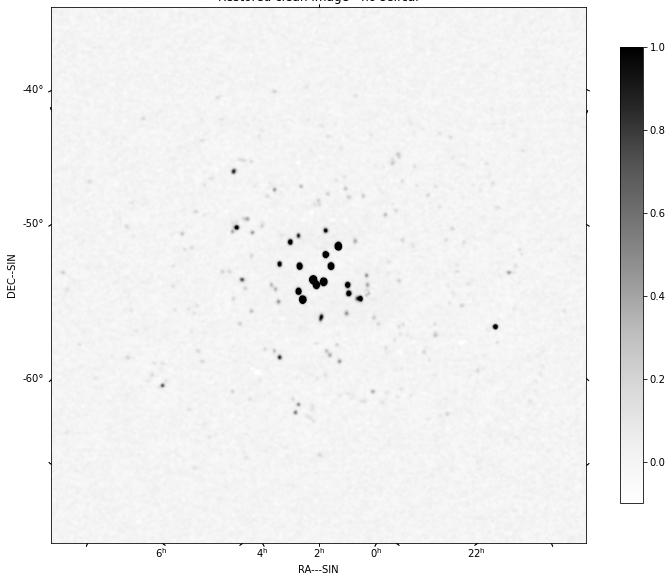

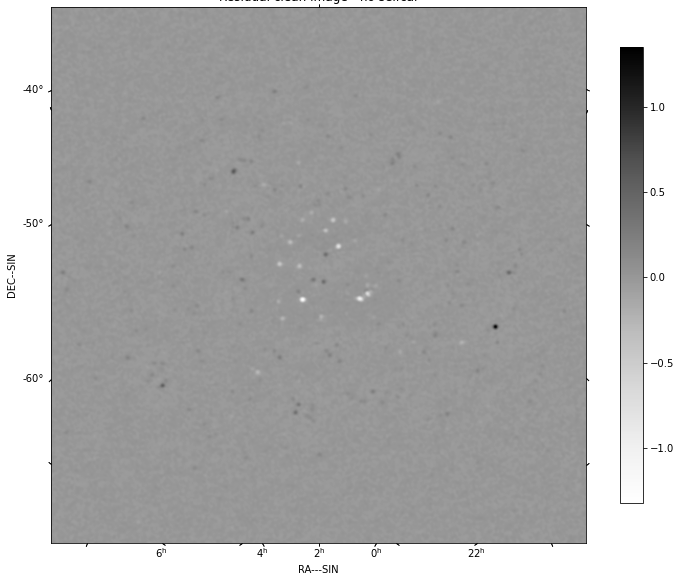

In [12]:
log.info('About to run continuum imaging')

centre=nfreqwin // 2
continuum_imaging_list=rsexecute.compute(continuum_imaging_list, sync=True)
deconvolved = continuum_imaging_list[0][centre]
residual = continuum_imaging_list[1][centre]
restored = continuum_imaging_list[2][centre]

f=show_image(deconvolved, title='Clean image - no selfcal', cm='Greys', 
             vmax=0.1, vmin=-0.01)
print(qa_image(deconvolved, context='Clean image - no selfcal'))

plt.show()

f=show_image(restored, title='Restored clean image - no selfcal', 
             cm='Greys', vmax=1.0, vmin=-0.1)
print(qa_image(restored, context='Restored clean image - no selfcal'))
plt.show()
export_image_to_fits(restored, '%s/imaging-dask_continuum_imaging_restored.fits' 
                     %(results_dir))

f=show_image(residual[0], title='Residual clean image - no selfcal', cm='Greys')
print(qa_image(residual[0], context='Residual clean image - no selfcal'))
plt.show()
export_image_to_fits(residual[0], '%s/imaging-dask_continuum_imaging_residual.fits' 
                     %(results_dir))
